In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")
import statistics as st
from scipy.stats import mode, skew, kurtosis
import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error ,mean_absolute_error
import seaborn as sns
from math import  sqrt
from sklearn import metrics
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
import warnings
warnings.filterwarnings("ignore")

In [ ]:
etr_df = pd.read_csv("/content/Ethereum Historical Data.csv")
etr_df

,Date,Price,Open,High,Low,Vol.,Change %
0,03/01/2024,"3,433.51","3,339.25","3,449.56","3,339.24",431.98K,2.82%
1,02/29/2024,"3,339.26","3,382.98","3,520.80","3,300.42",802.17K,-1.29%
2,02/28/2024,"3,383.03","3,242.44","3,482.48","3,183.92",1.01M,4.35%
3,02/27/2024,"3,242.14","3,175.94","3,285.01","3,165.91",674.56K,2.08%
4,02/26/2024,"3,175.94","3,112.59","3,193.67","3,038.00",582.39K,2.04%
...,...,...,...,...,...,...,...
1823,03/05/2019,136.82,125.97,141.11,125.44,16.74M,8.61%
1824,03/04/2019,125.97,131.02,131.57,123.25,14.11M,-3.85%
1825,03/03/2019,131.01,132.77,168.42,129.05,10.64M,-1.32%
1826,03/02/2019,132.76,135.72,136.36,130.74,11.29M,-2.18%


In [ ]:
# Format "Date" column
etr_df['Date'] = pd.to_datetime(etr_df['Date'], format='%m/%d/%Y')
etr_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-01,"3,433.51","3,339.25","3,449.56","3,339.24",431.98K,2.82%
1,2024-02-29,"3,339.26","3,382.98","3,520.80","3,300.42",802.17K,-1.29%
2,2024-02-28,"3,383.03","3,242.44","3,482.48","3,183.92",1.01M,4.35%
3,2024-02-27,"3,242.14","3,175.94","3,285.01","3,165.91",674.56K,2.08%
4,2024-02-26,"3,175.94","3,112.59","3,193.67","3,038.00",582.39K,2.04%
...,...,...,...,...,...,...,...
1823,2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
1824,2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
1825,2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%
1826,2019-03-02,132.76,135.72,136.36,130.74,11.29M,-2.18%


In [ ]:
print(etr_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1828 entries, 0 to 1827
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Date      1828 non-null   datetime64[ns]
 1   Price     1828 non-null   object        
 2   Open      1828 non-null   object        
 3   High      1828 non-null   object        
 4   Low       1828 non-null   object        
 5   Vol.      1828 non-null   object        
 6   Change %  1828 non-null   object        
dtypes: datetime64[ns](1), object(6)
memory usage: 100.1+ KB
None


In [ ]:
etr_df['Price'] = etr_df['Price'].str.replace(',', '').astype(float)
etr_df['Open'] = etr_df['Open'].str.replace(',', '').astype(float)
etr_df['High'] = etr_df['High'].str.replace(',', '').astype(float)
etr_df['Low'] = etr_df['Low'].str.replace(',', '').astype(float)
etr_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-01,3433.51,3339.25,3449.56,3339.24,431.98K,2.82%
1,2024-02-29,3339.26,3382.98,3520.80,3300.42,802.17K,-1.29%
2,2024-02-28,3383.03,3242.44,3482.48,3183.92,1.01M,4.35%
3,2024-02-27,3242.14,3175.94,3285.01,3165.91,674.56K,2.08%
4,2024-02-26,3175.94,3112.59,3193.67,3038.00,582.39K,2.04%
...,...,...,...,...,...,...,...
1823,2019-03-05,136.82,125.97,141.11,125.44,16.74M,8.61%
1824,2019-03-04,125.97,131.02,131.57,123.25,14.11M,-3.85%
1825,2019-03-03,131.01,132.77,168.42,129.05,10.64M,-1.32%
1826,2019-03-02,132.76,135.72,136.36,130.74,11.29M,-2.18%


In [ ]:
# Hàm để chuyển đổi giá trị có 'K', 'M', hoặc 'B' thành số thực.
def convert_volume(value):
    if 'K' in value:
        return float(value.replace('K', '')) * 1e3
    elif 'M' in value:
        return float(value.replace('M', '')) * 1e6
    elif 'B' in value:
        return float(value.replace('B', '')) * 1e9
    else:
        return float(value)

# Áp dụng hàm cho mỗi giá trị trong cột 'Vol.'.
etr_df['Vol.'] = etr_df['Vol.'].apply(convert_volume)


In [ ]:
etr_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-01,3433.51,3339.25,3449.56,3339.24,431980.0,2.82%
1,2024-02-29,3339.26,3382.98,3520.80,3300.42,802170.0,-1.29%
2,2024-02-28,3383.03,3242.44,3482.48,3183.92,1010000.0,4.35%
3,2024-02-27,3242.14,3175.94,3285.01,3165.91,674560.0,2.08%
4,2024-02-26,3175.94,3112.59,3193.67,3038.00,582390.0,2.04%
...,...,...,...,...,...,...,...
1823,2019-03-05,136.82,125.97,141.11,125.44,16740000.0,8.61%
1824,2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-3.85%
1825,2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-1.32%
1826,2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-2.18%


In [ ]:
# Hàm để chuyển đổi giá trị có dấu % thành số thực.
def convert_percent_to_float(value):
    return float(value.replace('%', '')) / 100

# Giả sử etr_df là DataFrame của bạn với cột 'Percentage' cần được chuyển đổi.
# etr_df['Percentage'] = ...

# Áp dụng hàm cho mỗi giá trị trong cột 'Percentage'.
etr_df['Change %'] = etr_df['Change %'].apply(convert_percent_to_float)


In [ ]:
etr_df

,Date,Price,Open,High,Low,Vol.,Change %
0,2024-03-01,3433.51,3339.25,3449.56,3339.24,431980.0,0.0282
1,2024-02-29,3339.26,3382.98,3520.80,3300.42,802170.0,-0.0129
2,2024-02-28,3383.03,3242.44,3482.48,3183.92,1010000.0,0.0435
3,2024-02-27,3242.14,3175.94,3285.01,3165.91,674560.0,0.0208
4,2024-02-26,3175.94,3112.59,3193.67,3038.00,582390.0,0.0204
...,...,...,...,...,...,...,...
1823,2019-03-05,136.82,125.97,141.11,125.44,16740000.0,0.0861
1824,2019-03-04,125.97,131.02,131.57,123.25,14110000.0,-0.0385
1825,2019-03-03,131.01,132.77,168.42,129.05,10640000.0,-0.0132
1826,2019-03-02,132.76,135.72,136.36,130.74,11290000.0,-0.0218


In [ ]:
etr_description = etr_df.describe()
etr_description

,Date,Price,Open,High,Low,Vol.,Change %
count,1828,1828.000000,1828.000000,1828.000000,1828.000000,1.828000e+03,1828.000000
mean,2021-08-30 12:00:00,1488.897462,1487.115602,1530.155525,1440.591324,1.525304e+07,0.002793
min,2019-03-01 00:00:00,107.900000,107.870000,117.910000,88.500000,2.703000e+04,-0.445500
25%,2020-05-30 18:00:00,258.687500,256.712500,267.527500,244.315000,5.088800e+05,-0.017600
50%,2021-08-30 12:00:00,1573.770000,1572.510000,1618.810000,1541.980000,1.415000e+06,0.001400
75%,2022-11-30 06:00:00,2152.582500,2151.725000,2226.717500,2077.777500,8.732500e+06,0.023325
max,2024-03-01 00:00:00,4808.380000,4808.340000,4864.060000,4715.430000,1.790000e+09,0.259600
std,NaN,1160.646264,1160.192223,1194.196874,1121.634079,1.149530e+08,0.044740


In [ ]:
# Tính toán các giá trị thống kê
variance_price = st.variance(etr_df["Price"])
std_dev_price = st.stdev(etr_df["Price"])
skewness_price = skew(etr_df["Price"])
kurtosis_price = kurtosis(etr_df["Price"])

print("Variance:", variance_price)
print("Standard Deviation:", std_dev_price)
print("Skewness:", skewness_price)
print("Kurtosis:", kurtosis_price)

Variance: 1347099.7494080034
Standard Deviation: 1160.6462636858844
Skewness: 0.5672070487439145
Kurtosis: -0.4398825843716776


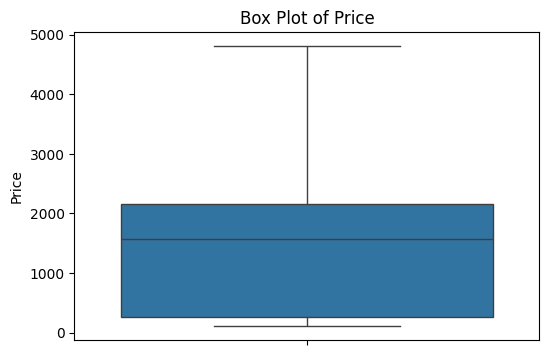

In [ ]:
plt.figure(figsize=(6, 4))
sns.boxplot(data=etr_df, y='Price')
plt.title('Box Plot of Price')
plt.ylabel('Price')
plt.show()

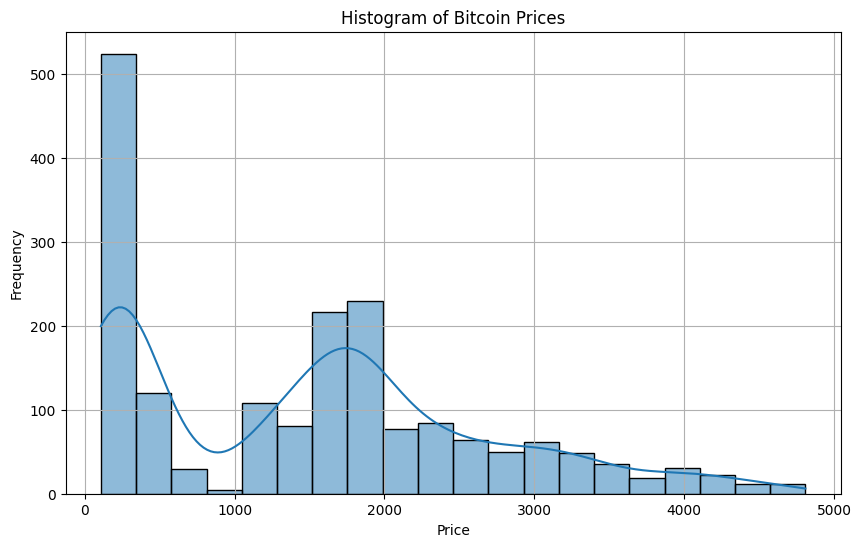

In [ ]:
plt.figure(figsize=(10, 6))
sns.histplot(etr_df['Price'], bins=20, kde=True)
plt.title('Histogram of Bitcoin Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

<Axes: >

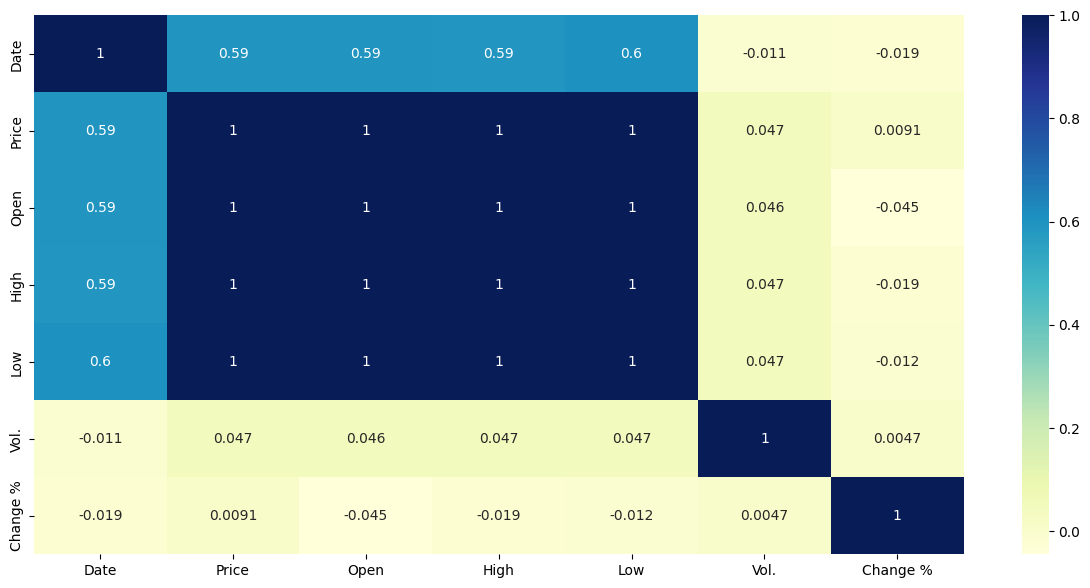

In [ ]:
plt.figure(figsize=(15,7))
sns.heatmap(etr_df.corr(),annot =True,cmap="YlGnBu")

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x = etr_df.drop(['Price'],axis =1 ).values
y = etr_df['Change %'].values

In [ ]:
new_df=etr_df.drop[['Price', 'Change %']]
X =new_df.drop(['Price'],axis = 1)
y = new_df['Change %']

TypeError: 'method' object is not subscriptable

In [ ]:
x

array([[Timestamp('2024-03-01 00:00:00'), 3339.25, 3449.56, 3339.24,
        431980.0, 0.0282],
       [Timestamp('2024-02-29 00:00:00'), 3382.98, 3520.8, 3300.42,
        802170.0, -0.0129],
       [Timestamp('2024-02-28 00:00:00'), 3242.44, 3482.48, 3183.92,
        1010000.0, 0.0435],
       ...,
       [Timestamp('2019-03-03 00:00:00'), 132.77, 168.42, 129.05,
        10640000.0, -0.0132],
       [Timestamp('2019-03-02 00:00:00'), 135.72, 136.36, 130.74,
        11290000.0, -0.0218],
       [Timestamp('2019-03-01 00:00:00'), 135.47, 138.06, 128.46,
        9730000.0, 0.0018]], dtype=object)

In [ ]:
y

array([ 0.0282, -0.0129,  0.0435, ..., -0.0132, -0.0218,  0.0018])

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [ ]:
x_train

array([[Timestamp('2022-09-19 00:00:00'), 1334.82, 1391.5, 1284.5,
        1110000.0, 0.030699999999999998],
       [Timestamp('2019-07-31 00:00:00'), 208.49, 218.19, 208.17,
        7510000.0, 0.04190000000000001],
       [Timestamp('2019-06-08 00:00:00'), 248.98, 250.51, 241.09,
        6230000.0, -0.0223],
       ...,
       [Timestamp('2021-10-23 00:00:00'), 3970.94, 4169.33, 3938.79,
        487030.0, 0.049800000000000004],
       [Timestamp('2020-03-03 00:00:00'), 231.9, 232.37, 220.34,
        18480000.0, -0.0342],
       [Timestamp('2021-01-30 00:00:00'), 1379.78, 1405.78, 1327.66,
        1590000.0, -0.0017000000000000001]], dtype=object)

In [ ]:
y_train

array([ 0.0307,  0.0419, -0.0223, ...,  0.0498, -0.0342, -0.0017])

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
X_scale = scaler.fit_transform(etr_df.iloc[:,2:7])
y_scale = scaler.fit_transform(etr_df['Price'].values.reshape(-1,1))

In [ ]:
print('X_scale.shape: ',X_scale.shape)
print('y_scale.shape: ',y_scale.shape)

X_scale.shape:  (1828, 5)
y_scale.shape:  (1828, 1)


In [ ]:
def train_test_split(X, y,test_size, window_size=10 ):
    split_index = int(len(X) * (1 - test_size))
    X_train = X[:split_index]
    y_train = y[:split_index]
    X_test = X[split_index:]
    y_test = y[split_index:]
    if window_size is not None:
        X_train = np.array([X_train[i:i+window_size] for i in range(len(X_train)-window_size)])
        y_train = y_train[window_size:]
        X_test = np.array([X_test[i:i+window_size] for i in range(len(X_test)-window_size)])
        y_test = y_test[window_size:]
    return X_train, y_train, X_test, y_test

In [ ]:
X_train, y_train, X_test, y_test = train_test_split(X_scale, y_scale, 0.2, 10)
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ',y_train.shape)
print('X_test.shape: ',X_test.shape)
print('y_test.shape: ',y_test.shape)

X_train.shape:  (1452, 10, 5)
y_train.shape:  (1452, 1)
X_test.shape:  (356, 10, 5)
y_test.shape:  (356, 1)
